# inspect ichthyop simulations

Setup diagnostics:

- absolute dispersion: 
    - maps of probability
    - integrate as a function of distance (probability displacement<1km ...)
    - condition on tides
- relative dispersion
    - setup pdf
    - integrate as a function of distance (probability separation<1km ...)


Rerun with larger dataset (launch every 5 days)

Need fix: some particle dive



In [25]:
import os
from glob import glob
from tqdm import tqdm

import numpy as np
import pandas as pd
import xarray as xr

import dask
from dask import delayed

from matplotlib import pyplot as plt
%matplotlib inline

import taos.utils as ut
import taos.mars as ms
import taos.drifters as dr

In [26]:
from dask.distributed import Client, LocalCluster

if False:
    cluster = LocalCluster()
else:
    from dask_jobqueue import PBSCluster
    cluster = PBSCluster()
    w = cluster.scale(jobs=5)
#
client = Client(cluster)
client

Connection method: Cluster object,Cluster type: dask_jobqueue.PBSCluster
Dashboard: http://10.148.0.93:8787/status,
Dashboard: http://10.148.0.93:8787/status,Workers: 0
Total threads: 0,Total memory: 0 B
Comm: tcp://10.148.0.93:50960,Workers: 0
Dashboard: http://10.148.0.93:8787/status,Total threads: 0
Started: Just now,Total memory: 0 B


---

## simulation paths

In [27]:
work_dir = "/home/datawork-lops-osi/aponte/taos/ichthy/lon0p25/"

# zarr archive that will concatenate relevant data
zarr = os.path.join(work_dir, "drifters_combined.zarr")

# reference latitude
lat_start0 = 49.35

In [28]:
# load 1 arbitrary snapshot for bathy
ds = ms.load_date("2011-01-01 00:00:00")

---

## one lagrangian simulation

In [5]:
run = "2011-08-10_lat{:.2f}".format(lat_start0)
run_dir = os.path.join(work_dir, run)

dsr = dr.load_run_simple(run_dir)
#dsr

**Some drifter used to dive !!**

Reason: the `age_max` parameter was set to 10 days, after what particles start to dive.
It is now 1000 which seems fix the problem.


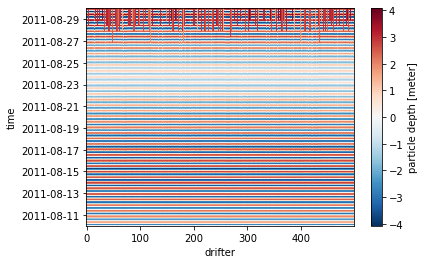

In [6]:
dsr.depth.plot()

(<Figure size 720x720 with 1 Axes>, <AxesSubplot:>)

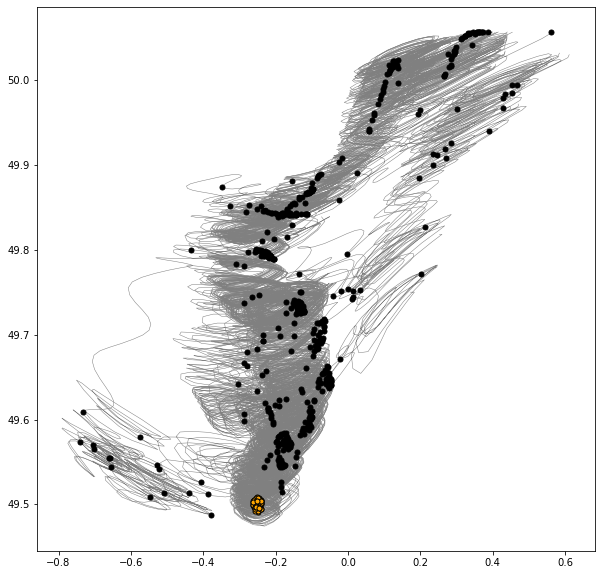

In [7]:
dr.plot_trajectories(dsr, dt=2)

(None,
 <GeoAxesSubplot:title={'center':'water depth [m]'}, xlabel='longitude [degrees_east]', ylabel='latitude [degrees_north]'>)

/home1/datahome/aponte/.miniconda3/envs/equinox/lib/python3.8/site-packages/cartopy/crs.py:228: ShapelyDeprecationWarning: __len__ for multi-part geometries is deprecated and will be removed in Shapely 2.0. Check the length of the `geoms` property instead to get the  number of parts of a multi-part geometry.
  if len(multi_line_string) > 1:
/home1/datahome/aponte/.miniconda3/envs/equinox/lib/python3.8/site-packages/cartopy/crs.py:280: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  for line in multi_line_string:
/home1/datahome/aponte/.miniconda3/envs/equinox/lib/python3.8/site-packages/cartopy/crs.py:347: ShapelyDeprecationWarning: __len__ for multi-part geometries is deprecated and will be removed in Shapely 2.0. Check the length of the `geoms` property instead to get the  number of parts of a multi-part geometry.
  if len(p_mline) > 0

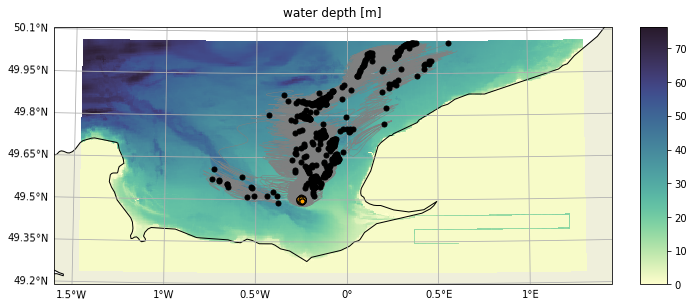

In [8]:
fac = ms.plot_bs(-ds["z"].isel(time=0, level=0), 
           title="water depth [m]",
           vmin=0,
           cmap=ms.cm.deep,
           zoom=0, figsize=0,
          )

dr.plot_trajectories(dsr, ax=fac["ax"], dt=2)

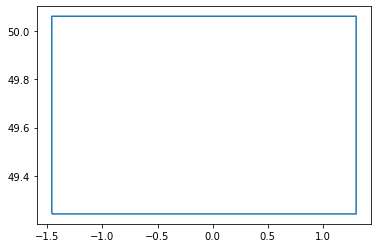

In [9]:
plt.plot(dsr.region_edge.squeeze()[:,1], dsr.region_edge.squeeze()[:,0])

---

## combine multiple runs into a single zarr archive

- combine into a single xarray dataset
- compute local coordinates
- store

In [10]:
def get_run_info(work_dir):
    """ get paths, date_start, lat_start
    """
    runs = sorted(glob(os.path.join(work_dir, "*-*_lat*")))
    runs = [r for r in runs if ".pbs" not in r]
    
    date_start = [r.split("/")[-1].split("_")[0] for r in runs]
    lat_start = [float(r.split("/")[-1]
                       .split("_")[1]
                       .replace("lat","")
                      ) for r in runs
                ]
    df = pd.DataFrame(dict(date_start=[pd.Timestamp(d) for d in date_start], 
                                       lat_start=lat_start, 
                                       files=runs))
    return df.set_index("date_start")

def load_run(r, template=None, verbose=False):
    """ Load a single run, massage dataset such as to 
    """
    
    # "/home/datawork-lops-osi/aponte/taos/ichthy/2011-02-01_lat49.32"
    _date = pd.Timestamp(r.split("/")[-1].split("_")[0])
    _lat = float(r
                 .split("/")[-1]
                 .split("_")[1]
                 .replace("lat","")
               )
    ds = dr.load_run_simple(r)
    
    if ds is None:
        # not output file, use template if provided
        if verbose:
            print("{}: no netcdf file found".format(r))
        if template is not None:
            ds = template.assign_coords(date_start=[_date], lat_start=[_lat])
            ds = ds.assign(done=~ds.done)
            ds["lon"] = xr.full_like(ds["lon"], np.NaN)
            ds["lat"] = xr.full_like(ds["lat"], np.NaN)
            return ds
        else:
            return
    #
    ds = dr.normalize_time(ds)
    ds = ds.expand_dims(date_start=[_date],
                        lat_start=[_lat]
                       )
    ds["region_edge"] = ds["region_edge"].squeeze()
    ds["done"] = (("date_start", "lat_start"), [[ds.attrs["done"]]])
    #del ds["region_edge"]
    #ds = ds.chunk(dict(lat_start=1))
    
    return ds

def combine_runs(df, template=None):
    #with dask.config.set(scheduler="threads"):        
    ds_all = [load_run(r, template=None, verbose=False) for r in df["files"]]
    ds_all = [ds for ds in ds_all if ds is not None]
    ds = xr.merge(ds_all)
    return ds

combine_runs_delayed = delayed(combine_runs)



def add_metrics(dsr):
    
    # transform lon, lat in local x/y
    #lon_ref = abs(float(dsr.attrs["release.stain.lon_stain"]))
    #lat_ref = abs(float(dsr.attrs["release.stain.lat_stain"]))
    lon_ref = -0.25
    lat_ref = 49.3

    dla = 111e3
    dlo = float(dla*np.cos(np.pi/180*lat_ref))

    dsr["x"] = (dsr.lon - lon_ref)*dlo
    dsr["y"] = (dsr.lat - lat_ref)*dla

    dsr["dx_absolute"] = dsr.x - dsr.x.isel(time=0)
    dsr["dy_absolute"] = dsr.y - dsr.y.isel(time=0)

    dsr["x_center"] = dsr["x"].mean("drifter")
    dsr["y_center"] = dsr["y"].mean("drifter")

    dsr["dx_relative"] = dsr["x"] - dsr["x_center"]
    dsr["dy_relative"] = dsr["y"] - dsr["y_center"]

    dsr["dispersion_absolute"] = dsr["dx_absolute"]**2 + dsr["dy_absolute"]**2
    dsr["dispersion_relative"] = dsr["dx_relative"]**2 + dsr["dy_relative"]**2
    
    return dsr
    

In [11]:
files = get_run_info(work_dir)

# load 1 drifter simulation, will be used as a template dataset
ds_template = load_run(files["files"].iloc[0]) 

In [12]:
# goes through with 10 days
#ds = combine_runs(files.loc["2011-02":"2011-02-10"], template=ds_template) 

In [13]:
#label = "2011-02"
#label = "2012-02"
#label = "2012-03"
#freq = "5D"

def process_top(files, label, overwrite=False):

    zarr = os.path.join(work_dir, "drifters_{}.zarr".format(label))

    if not os.path.isdir(zarr) or overwrite:

        _files = files.loc[label]

        delayed_outputs = [combine_runs_delayed(g, template=ds_template) 
                           for label, g in _files.groupby(_files.index)
                          ]
        # _files.groupby(pd.Grouper(freq=freq)
        outputs = dask.compute(delayed_outputs)

        ds = xr.concat(outputs[0], dim="date_start")

        ds = add_metrics(ds)

        # rechunk and store
        #dsr = dsr.chunk(dict(date_start=50))
        ds.to_zarr(zarr, mode="w")

In [14]:
for label, g in tqdm(files.groupby(pd.Grouper(freq="1M"))):
    process_top(g, label.strftime("%Y-%m"), overwrite=True) 

100%|██████████| 37/37 [14:25<00:00, 23.38s/it]


In [22]:
# concatenate one last time along time
zarrs = glob(os.path.join(work_dir, "drifters_*.zarr"))

ds = xr.concat([xr.open_zarr(z) for z in zarrs], dim="date_start")
ds = ds.chunk(dict(date_start=50)) # lat_start=-1?
ds = _reset_chunk_encoding(ds)

zarr = os.path.join(work_dir, "drifters.zarr")
ds.to_zarr(zarr, mode="w")

/home1/datahome/aponte/.miniconda3/envs/equinox/lib/python3.8/site-packages/xarray/core/dataset.py:2031: SerializationWarning: saving variable None with floating point data as an integer dtype without any _FillValue to use for NaNs
  return to_zarr(


In [ ]:
# old stuff below, disregard

In [ ]:
#runs = sorted(glob(os.path.join(work_dir, "2011-02*_lat49.3*")))
#runs = sorted(glob(os.path.join(work_dir, "2011-02*_lat*")))
runs = sorted(glob(os.path.join(work_dir, "2011-*_lat*")))
runs = [r for r in runs if ".pbs" not in r]

# extract start dates and location
date_start = set([r.split("/")[-1].split("_")[0] for r in runs])
lat_start = set([float(r.split("/")[-1]
                       .split("_")[1]
                       .replace("lat","")
                      ) for r in runs])
date_start = sorted(list(date_start)) # iteration over set is not sorted
lat_start = sorted(list(lat_start))

# load 1 drifter simulation, will be used as a template dataset
ds1 = load_run(runs[0])
#ds1

In [ ]:
get_run_path = lambda date, lat: os.path.join(work_dir, date+"_lat{:.2f}".format(lat))

_dsr = [[load_run(get_run_path(date, lat), template=ds1, verbose=False) 
         for date in date_start]
        for lat in lat_start]

#dsr = xr.merge([ds for ds in _dsr if ds is not None]) # crashes the kernel
dsr = (xr.combine_nested(_dsr, 
                         concat_dim=["lat_start", "date_start"], 
                         combine_attrs="override",
                        )
       .persist()
      )

# !!! should do with xarray.open_mfdataset !!!

# .nc.part files are not converted totally

# 2011-12-22_lat49.42
# (equinox) taos/ichthy% grep 2011-12-22_lat49.42 icl*
# icl162.o7788552:ichthyop[info] Opened configuration file /home/datawork-lops-osi/aponte/taos/ichthy/2011-12-22_lat49.42/cfg.xml
# icl162.o7788552:ichthyop[info] Created output file /home/datawork-lops-osi/aponte/taos/ichthy/2011-12-22_lat49.42/output/taos__ichthyop-run202111092302.nc.part
#ichthyop[info] Step 2868 / 7200
# ichthyop[severe] An error occured while running the simulation | java.io.IOException: [Dataset] Unable to find any file following /home/ref-oc-public/modeles_marc/f1_e2500_agrif/MARC_F1-MARS3D-SEINE/best_estimate/2011/MARC_F1-MARS3D-SEINE_20111231T2300Z.nc

# ichthyop[severe] An error occured while running the simulation | java.io.IOException: [Dataset] Unable to find any file following /home/ref-oc-public/modeles_marc/f1_e2500_agrif/MARC_F1-MARS3D-SEINE/best_estimate/2011/MARC_F1-MARS3D-SEINE_20111231T2300Z.nc

---

## inspect combined result: focus on a single location

In [29]:
# reload data
zarr = os.path.join(work_dir, "drifters.zarr")
dsr = xr.open_zarr(zarr).persist()

In [30]:
print("Number of trajectories: {}".format(dsr.done.size))
print("{} different initial latitudes: min {}, max {}".format(dsr.lat_start.size,
                                                              float(dsr.lat_start.min()),
                                                              float(dsr.lat_start.max()),
                                                             )
     )
print("{} different starting dates: min {}, max {}".format(dsr.date_start.size,
                                                           dsr.date_start.min().values,
                                                           dsr.date_start.max().values,
                                                          )
     )

Number of trajectories: 11529
21 different initial latitudes: min 49.3, max 49.7
549 different starting dates: min 2011-02-01T00:00:00.000000000, max 2014-02-01T00:00:00.000000000


### Absolute dispersion

/home1/datahome/aponte/.miniconda3/envs/equinox/lib/python3.8/site-packages/cartopy/crs.py:228: ShapelyDeprecationWarning: __len__ for multi-part geometries is deprecated and will be removed in Shapely 2.0. Check the length of the `geoms` property instead to get the  number of parts of a multi-part geometry.
  if len(multi_line_string) > 1:
/home1/datahome/aponte/.miniconda3/envs/equinox/lib/python3.8/site-packages/cartopy/crs.py:280: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  for line in multi_line_string:
/home1/datahome/aponte/.miniconda3/envs/equinox/lib/python3.8/site-packages/cartopy/crs.py:347: ShapelyDeprecationWarning: __len__ for multi-part geometries is deprecated and will be removed in Shapely 2.0. Check the length of the `geoms` property instead to get the  number of parts of a multi-part geometry.
  if len(p_mline) > 0

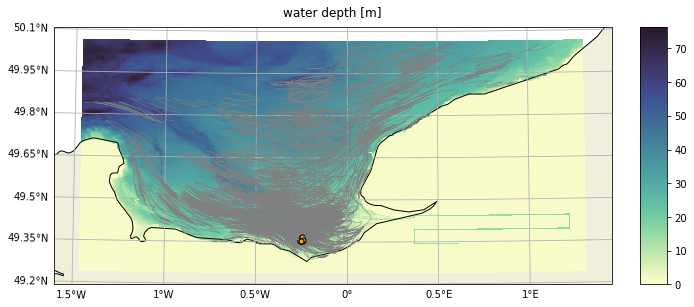

In [32]:
# not great
fac = ms.plot_bs(-ds["z"].isel(time=0, level=0), 
           title="water depth [m]",
           vmin=0,
           cmap=ms.cm.deep,
           zoom=0, figsize=0,
          )

_ds = (dsr
       .sel(lat_start=lat_start0, method="nearest")
       .isel(drifter=[0])
      )
for _d in _ds.date_start[::10]:
    dr.plot_trajectories(_ds.sel(date_start=_d), ax=fac["ax"])

In [33]:
h = dr.bin_geographically(dsr)
#np.log10(h.isel(time=range(0,24*20,24))).plot(x="lon_bin", y="lat_bin", col="time", col_wrap=3)

/home1/datahome/aponte/.miniconda3/envs/equinox/lib/python3.8/site-packages/cartopy/crs.py:228: ShapelyDeprecationWarning: __len__ for multi-part geometries is deprecated and will be removed in Shapely 2.0. Check the length of the `geoms` property instead to get the  number of parts of a multi-part geometry.
  if len(multi_line_string) > 1:
/home1/datahome/aponte/.miniconda3/envs/equinox/lib/python3.8/site-packages/cartopy/crs.py:280: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  for line in multi_line_string:
/home1/datahome/aponte/.miniconda3/envs/equinox/lib/python3.8/site-packages/cartopy/crs.py:347: ShapelyDeprecationWarning: __len__ for multi-part geometries is deprecated and will be removed in Shapely 2.0. Check the length of the `geoms` property instead to get the  number of parts of a multi-part geometry.
  if len(p_mline) > 0

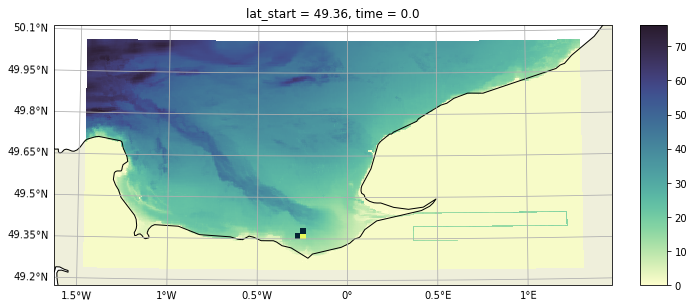

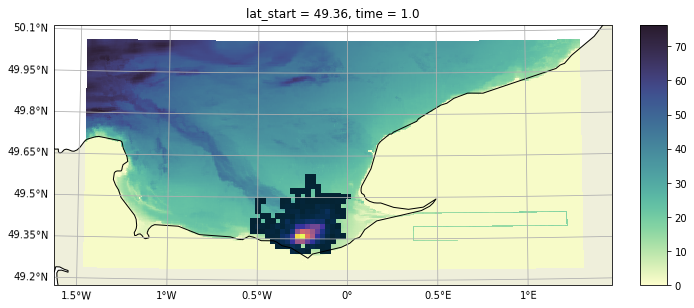

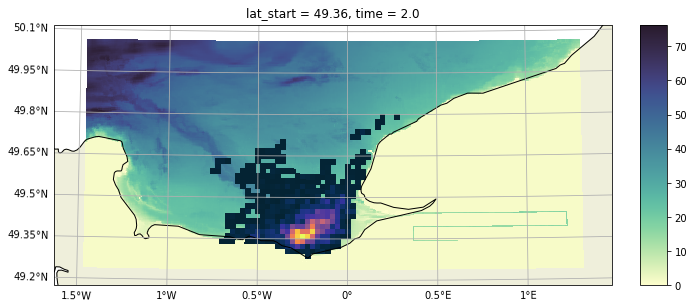

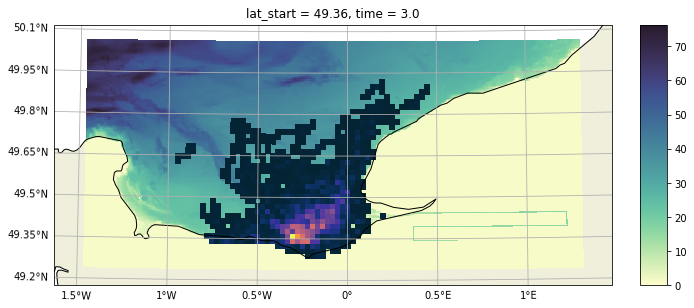

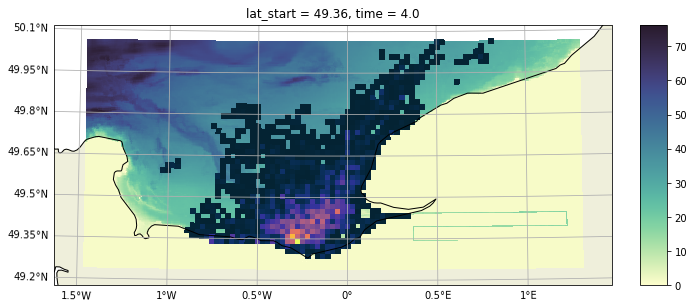

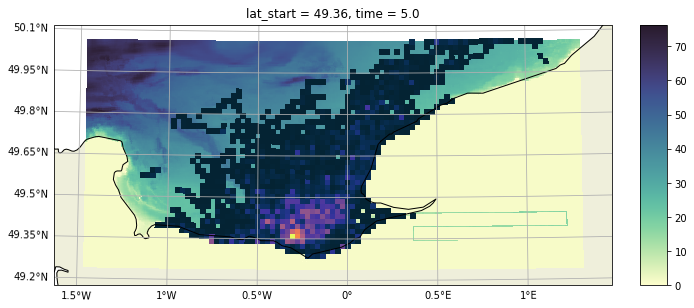

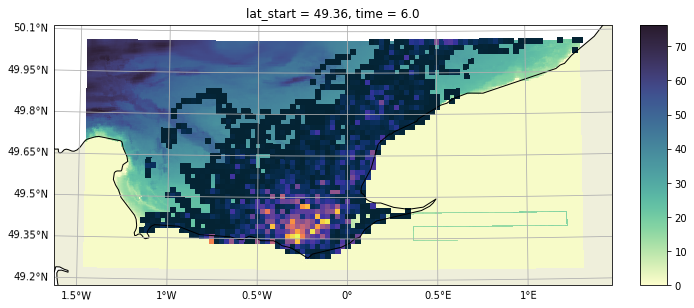

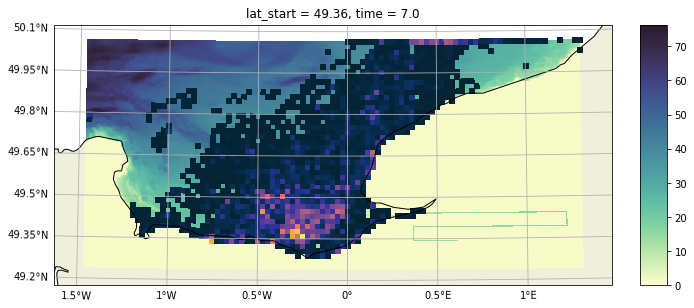

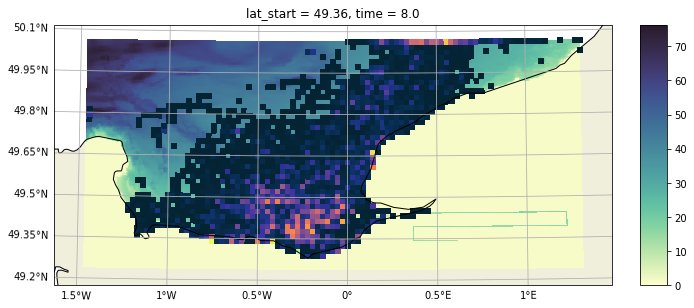

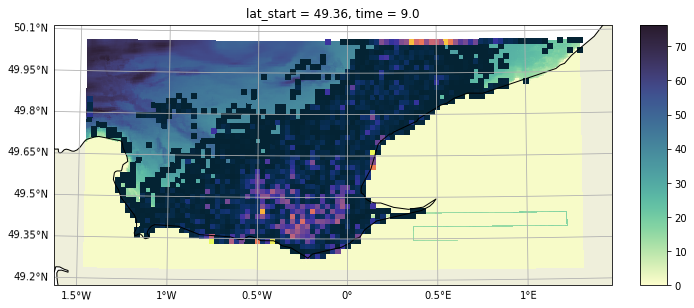

In [34]:
_h = h.sel(lat_start=lat_start0, method="nearest")

for t in range(0,24*10,24):

    fac = ms.plot_bs(-ds["z"].isel(time=0, level=0), 
               title="water depth [m]",
               vmin=0,
               cmap=ms.cm.deep,
               zoom=0, figsize=0,
              )
    toplt = _h.isel(time=t)
    toplt = toplt.where(toplt>0) # mask 0s
    #toplt = np.log10(toplt)
    (toplt
     .plot
     .pcolormesh(ax=fac["ax"], 
                 x="lon_bin", y="lat_bin",
                 cmap=ms.cm.thermal,
                 add_colorbar=False,
                 transform=dr.ccrs.PlateCarree(),
                )
    )

### in meters

In [35]:
h = dr.bin_displacements(dsr.dx_absolute, dsr.dy_absolute, dl_max=40e3)

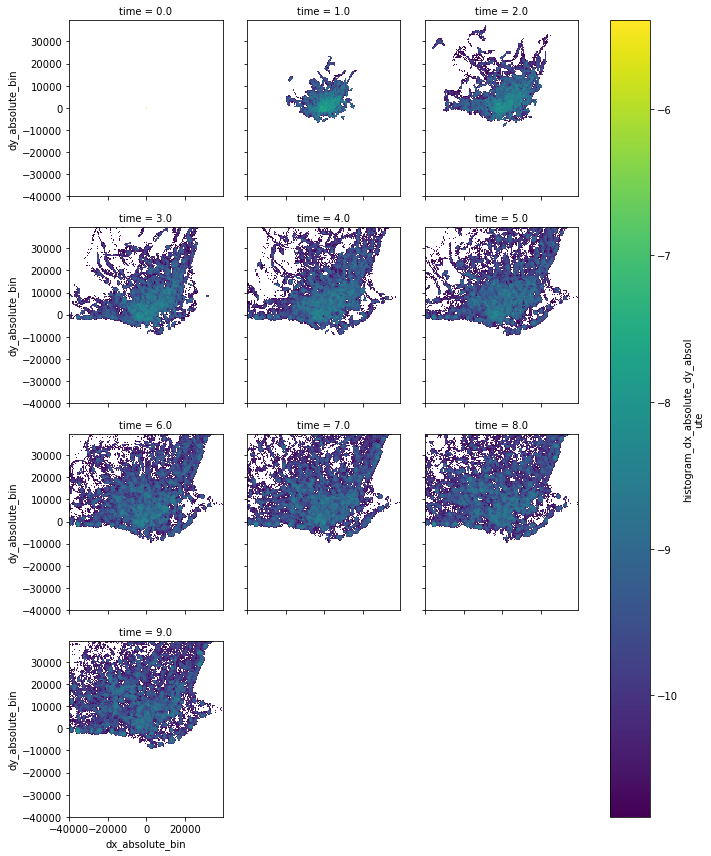

In [36]:
_h = h.sel(lat_start=lat_start0, method="nearest")

toplt = _h.isel(time=range(0,24*10,24))
toplt = toplt.where(toplt>0)
toplt = np.log10(toplt)
toplt.plot(x="dx_absolute_bin", y="dy_absolute_bin", col="time", col_wrap=3)

In [37]:
dispersion = dr.bin_displacement(dsr.dispersion_absolute, 
                                 dl_max=(40e3)**2, 
                                 dl_step=500**2,
                                )

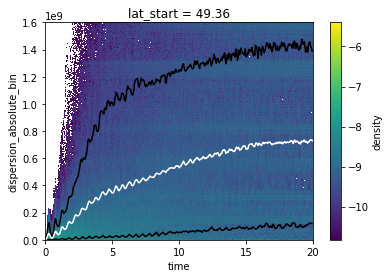

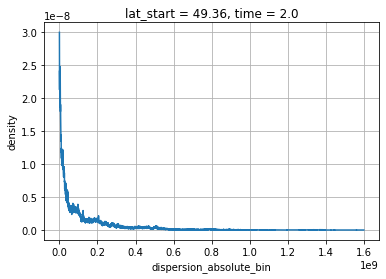

In [68]:
_ds = dispersion.sel(lat_start=lat_start0, method="nearest")
#_ds = _ds.sel(time=slice(0, 5))

_h = _ds["density"]

#toplt = _h.isel(time=range(0,24*10,24))
toplt = _h
#toplt = toplt.where(toplt>0)
toplt = np.log10(toplt)

fig, ax = plt.subplots(1,1)
toplt.plot(ax=ax, x="time", y="dispersion_absolute_bin")
_ds["cum"].plot.contour(levels=[0.1, 0.9], colors="k", x="time", y="dispersion_absolute_bin")
ax.plot(_h.time, _ds["mean"], color="w")
ax.set_ylim((0,40e3**2))
#ax.set_ylim((2*1e2**2,40e3**2))
#ax.set_yscale("log")

fig, ax = plt.subplots(1,1)
_h.sel(time=2, method="nearest").plot(ax=ax)
ax.grid()

### Relative dispersion

In [44]:
h = dr.bin_displacements(dsr.dx_relative, dsr.dy_relative, dl_max=40e3)

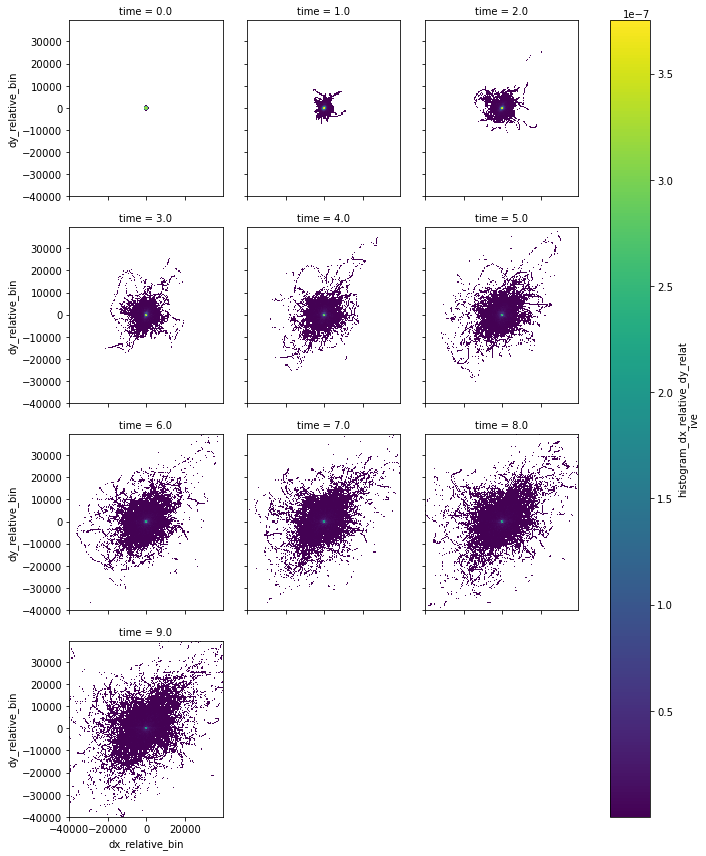

In [45]:
_h = h.sel(lat_start=lat_start0, method="nearest")

toplt = _h.isel(time=range(0,24*10,24))
toplt = toplt.where(toplt>0)
#toplt = np.log10(toplt)

toplt.plot(x="dx_relative_bin", y="dy_relative_bin", col="time", col_wrap=3)

In [47]:
dispersion_relative = dr.bin_displacement(dsr.dispersion_relative, 
                                          dl_max=20e3**2,
                                          dl_step=500**2,
                                         )

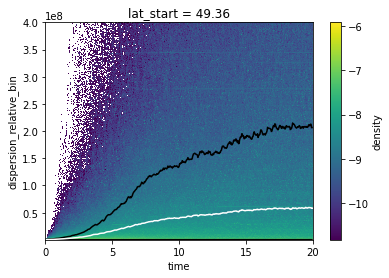

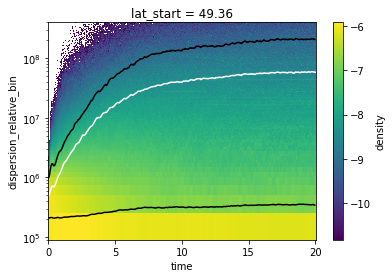

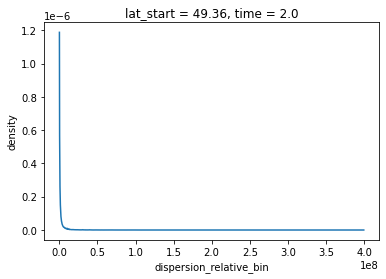

In [69]:
_ds = dispersion_relative.sel(lat_start=lat_start0, method="nearest")
#_ds = _ds.sel(time=slice(0, 5))

_h = _ds["density"]

toplt = _h
#toplt = toplt.where(toplt>0)
toplt = np.log10(toplt)


fig, ax = plt.subplots(1,1)

toplt.plot(ax=ax, x="time", y="dispersion_relative_bin")
_ds["cum"].plot.contour(levels=[0.1, 0.9], colors="k", x="time", y="dispersion_relative_bin")
ax.plot(_h.time, _ds["mean"], color="w")
ax.set_ylim(300**2,20e3**2)
#ax.set_yscale("log")
#ax.set_xlim(.1,20)
#ax.set_xscale("log")

fig, ax = plt.subplots(1,1)
toplt.plot(ax=ax, x="time", y="dispersion_relative_bin")
_ds["cum"].plot.contour(levels=[0.1, 0.9], colors="k", x="time", y="dispersion_relative_bin")
ax.plot(_h.time, _ds["mean"], color="w")
ax.set_ylim(300**2,20e3**2)
ax.set_yscale("log")
#ax.set_xlim(.1,20)
#ax.set_xscale("log")

fig, ax = plt.subplots(1,1)
_h.sel(time=2, method="nearest").plot(ax=ax)


## tidal conditionning

In [134]:
# date_start is not sorted at this point
#plt.plot(_ds.date_start.values - _ds.date_start.min().values)

dsr = dsr.sortby("date_start")

/home1/datahome/aponte/.miniconda3/envs/equinox/lib/python3.8/site-packages/xarray/core/indexing.py:1226: PerformanceWarning: Slicing is producing a large chunk. To accept the large
chunk and silence this warning, set the option
    >>> with dask.config.set(**{'array.slicing.split_large_chunks': False}):
    ...     array[indexer]

To avoid creating the large chunks, set the option
    >>> with dask.config.set(**{'array.slicing.split_large_chunks': True}):
    ...     array[indexer]
  return self.array[key]


In [231]:
#_ds = dsr.sel(lat_start=lat_start0, method="nearest").persist()
_ds = dsr.sel(lat_start=49.5, method="nearest").persist()

### load tidal envelopes

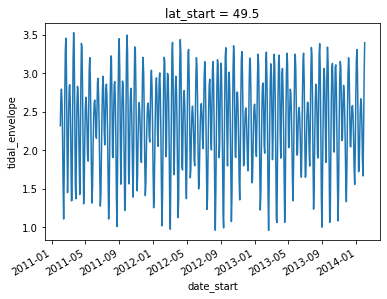

In [234]:
dsh = ut.predict_tides(_ds.date_start, real=False, summed=False)
envelope = abs(dsh["complex"].where( (dsh.frequency>1.5) & (dsh.frequency<2.5)).sum("constituent"))
_ds["tidal_envelope"] = ("date_start", envelope.data)

_ds["tidal_envelope"].plot(x="date_start")

(array([12.,  6., 13., 21., 20., 19., 27., 38., 28., 39., 32., 36., 55.,
        36., 42., 37., 28., 35., 19.,  6.]),
 array([0.95932147, 1.08773999, 1.2161585 , 1.34457702, 1.47299554,
        1.60141406, 1.72983258, 1.8582511 , 1.98666961, 2.11508813,
        2.24350665, 2.37192517, 2.50034369, 2.6287622 , 2.75718072,
        2.88559924, 3.01401776, 3.14243628, 3.27085479, 3.39927331,
        3.52769183]),
 <BarContainer object of 20 artists>)

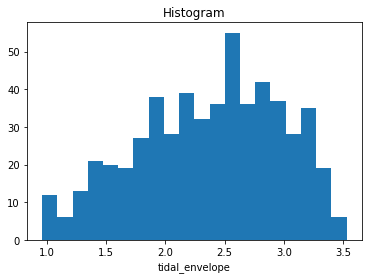

In [235]:
_ds["tidal_envelope"].plot.hist(bins=20)

In [236]:
def get_histo(da0, da1, bins=(1, 3.5, .5), dims=["date_start", "drifter"]):

    h = histogram((da0+da1*0).rename("tidal_envelope"), bins=[np.arange(*bins),], 
                   dim=dims,
                   weights=da1,
                   density=False,
                   bin_dim_suffix="",
                 )
    count = histogram((da0+da1*0).rename("tidal_envelope"), bins=[np.arange(*bins),], 
                   dim=dims,
                   density=False,
                   bin_dim_suffix="",
                     )
    h = (h/count).rename(da1.name)
    return h

In [237]:
h = get_histo(_ds.tidal_envelope, _ds.dispersion_absolute).persist()

Text(0.5, 1.0, 'absolute dispersion as a function of tidal amplitude')

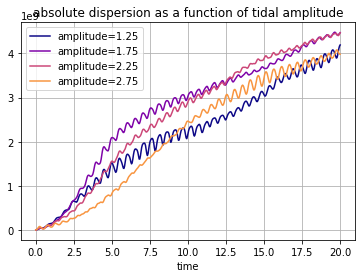

In [239]:
#colors = ut.get_cmap_colors(h.tidal_envelope.size, cmap='plasma')

fig, ax = plt.subplots(1,1)

for e, c in zip(h.tidal_envelope, colors):
    _h = h.sel(tidal_envelope=e)
    _h.plot(ax=ax, x="time", color=c, label="amplitude={}".format(float(e)))

ax.legend()
ax.grid()
ax.set_ylabel("")
ax.set_title("absolute dispersion as a function of tidal amplitude")

Text(0.5, 1.0, 'absolute dispersion as a function of tidal range')

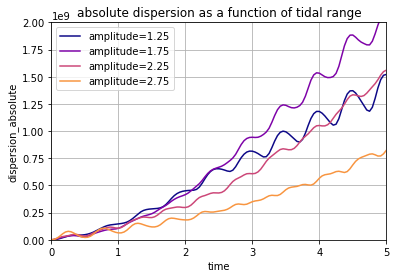

In [240]:
fig, ax = plt.subplots(1,1)

for e, c in zip(h.tidal_envelope, colors):
    _h = h.sel(tidal_envelope=e)
    _h.plot(ax=ax, x="time", color=c, label="amplitude={}".format(float(e)))

ax.set_xlim(0,5)
ax.set_ylim(0,2e9)
ax.legend()
ax.grid()
ax.set_title("absolute dispersion as a function of tidal range")

In [241]:
h = get_histo(_ds.tidal_envelope, _ds.dispersion_relative).persist()

Text(0.5, 1.0, 'relative dispersion as a function of tidal amplitude')

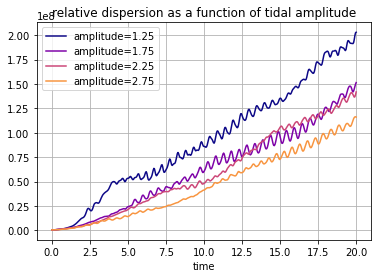

In [242]:

fig, ax = plt.subplots(1,1)

for e, c in zip(h.tidal_envelope, colors):
    _h = h.sel(tidal_envelope=e)
    _h.plot(ax=ax, x="time", color=c, label="amplitude={}".format(float(e)))

ax.legend()
ax.grid()
ax.set_ylabel("")
ax.set_title("relative dispersion as a function of tidal amplitude")

Text(0.5, 1.0, 'relative dispersion as a function of tidal range')

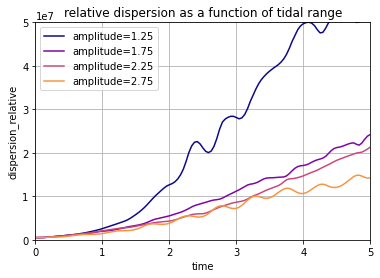

In [243]:
fig, ax = plt.subplots(1,1)

for e, c in zip(h.tidal_envelope, colors):
    _h = h.sel(tidal_envelope=e)
    _h.plot(ax=ax, x="time", color=c, label="amplitude={}".format(float(e)))

ax.set_xlim(0,5)
ax.set_ylim(0,5e7)
ax.legend()
ax.grid()
ax.set_title("relative dispersion as a function of tidal range")

---

## inspect combined result: focus on all locations

In [81]:
dsr_mean = dsr.mean(["drifter", "date_start"]).persist()

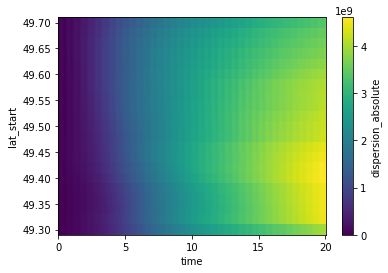

In [84]:
dsr_mean.dispersion_absolute.plot(x="time", y="lat_start")
#.sel(time=2, method="nearest")

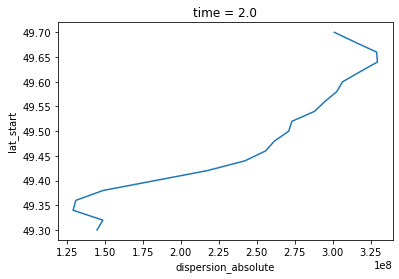

In [86]:
dsr_mean.dispersion_absolute.sel(time=2, method="nearest").plot(y="lat_start")

In [89]:
np.sqrt(2e8/(86400*2)**2)

0.08184106263733189

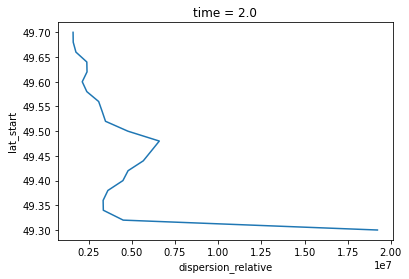

In [90]:
dsr_mean.dispersion_relative.sel(time=2, method="nearest").plot(y="lat_start")

In [ ]:
#compute fraction of drifters that have reached the bdy
#compute fraction of drifters that have beached

dsr["exited"] = xr.full_like(dsr.mortality, 1.).where(dsr.mortality==2, other=0)
dsr["beached"] = xr.full_like(dsr.mortality, 1.).where(dsr.mortality==4, other=0)

dsr = dsr.persist()

In [ ]:
_ds = dsr["exited"].mean(["date_start", "drifter"])
_ds.plot(vmax=1.)

In [ ]:
_ds = dsr["beached"].mean(["date_start", "drifter"])
_ds.plot(vmax=1.)

In [ ]:
_h = h.sel(time=5., method="nearest")

for lat in range(0, _h.lat_start.size, 5):

    fac = ms.plot_bs(-ds["z"].isel(time=0, level=0), 
               title="water depth [m]",
               vmin=0,
               cmap=ms.cm.deep,
               zoom=0, figsize=0,
              )
        
    (np.log10(_h.isel(lat_start=lat))
     .plot
     .pcolormesh(ax=fac["ax"], 
                 x="lon_bin", y="lat_bin",
                 cmap=ms.cm.thermal,
                 add_colorbar=False,
                 transform=dr.ccrs.PlateCarree(),
                )
    )

Bin absolute displacement

In [ ]:
dl = dsr["dl_absolute"].mean(["drifter", "date_start"]).persist()

In [ ]:
(dl/1e3).plot()

In [71]:
dsr

<xarray.Dataset>
Dimensions:              (date_start: 549, lat_start: 21, time: 481, drifter: 500, edge: 1188, latlon: 2)
Coordinates:
  * date_start           (date_start) datetime64[ns] 2011-04-02 ... 2013-03-30
  * lat_start            (lat_start) float64 49.3 49.32 49.34 ... 49.68 49.7
  * time                 (time) float64 0.0 0.04167 0.08333 ... 19.92 19.96 20.0
Dimensions without coordinates: drifter, edge, latlon
Data variables: (12/17)
    date                 (date_start, lat_start, time) datetime64[ns] dask.array<chunksize=(138, 6, 121), meta=np.ndarray>
    depth                (date_start, lat_start, time, drifter) float32 dask.array<chunksize=(50, 6, 121, 125), meta=np.ndarray>
    dispersion_absolute  (date_start, lat_start, time, drifter) float32 dask.array<chunksize=(50, 6, 121, 125), meta=np.ndarray>
    dispersion_relative  (date_start, lat_start, time, drifter) float32 dask.array<chunksize=(50, 6, 121, 125), meta=np.ndarray>
    done                 (date_start, lat_start) float64 dask.array<chunksize=(50, 21), meta=np.ndarray>
    dx_absolute          (date_start, lat_start, time, drifter) float32 dask.array<chunksize=(50, 6, 121, 125), meta=np.ndarray>
    ...                   ...
    mortality            (date_start, lat_start, time, drifter) float64 dask.array<chunksize=(50, 6, 121, 125), meta=np.ndarray>
    region_edge          (date_start, edge, latlon) float32 dask.array<chunksize=(50, 1188, 2), meta=np.ndarray>
    x                    (date_start, lat_start, time, drifter) float32 dask.array<chunksize=(50, 6, 121, 125), meta=np.ndarray>
    x_center             (date_start, lat_start, time) float32 dask.array<chunksize=(50, 21, 481), meta=np.ndarray>
    y                    (date_start, lat_start, time, drifter) float32 dask.array<chunksize=(50, 6, 121, 125), meta=np.ndarray>
    y_center             (date_start, lat_start, time) float32 dask.array<chunksize=(50, 21, 481), meta=np.ndarray>
Attributes: (12/67)
    action.advection.enabled:                 true
    action.advection.scheme:                  Runge Kutta 4
    action.buoyancy.age_max:                  1000.0
    action.buoyancy.density_file:             
    action.buoyancy.enabled:                  true
    action.buoyancy.particle_density:         0.9
    ...                                       ...
    release.stain.radius_stain:               1000
    release.stain.thickness_stain:            1.0
    release.txtfile.enabled:                  false
    release.zone.enabled:                     false
    transport_dimension:                      3d
    xml_file:                                 /home/datawork-lops-osi/aponte/...

---

In [ ]:
cluster.close()